In [2]:
import warnings
from pathlib import Path
import json
import re
from multiprocessing import Pool

import numpy as np  

import corner

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import ufloat
from uncertainties.unumpy import nominal_values
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia

from dust_extinction.parameter_averages import F99, F04, G23

from deblib.constants import M_sun, R_sun
from deblib.stellar import log_g

from libs import extinction
from libs.pipeline import get_teff_from_spt
from libs.sed import get_sed_for_target, create_outliers_mask, group_and_average_fluxes
from libs.sed_fit import create_theta, model_func, minimize_fit, mcmc_fit
from libs.plots import plot_sed
from libs.stellar_grids import BtSettlGrid

### Load the bt-settle-agss grids and set up the related model functions 

The ModelSed loads a grid of pre-filtered fluxes across a range of $T_{\rm eff}$, $\log{g}$ and 
metallicities into a `RegularGridInterpolator`s, one per filter.

For now we consider only the data for solar metallicity, hence the interpolators only cover
$[{\rm Fe/H}] = 0$ and $[{\rm \alpha/Fe}] = 0$, however additional axes/dimensions
for $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$ may be added, if required.

In [3]:
# Model SED grid based on bt-settl-agss models with known filters pre-applied to non-reddened fluxes
model_grid = BtSettlGrid()

print(f"Loaded grid of solar metallicity fluxes, based on bt-settl models, covering the ranges:")
print(f"wavelength {model_grid.wavelength_range * model_grid.wavelength_unit:unicode},",
      f"Teff {model_grid.teff_range * model_grid.teff_unit:unicode}",
      f"and logg {model_grid.logg_range * model_grid.logg_unit:unicode}",
      f"with fluxes returned in units of {model_grid.flux_unit:unicode}")

Loaded grid of solar metallicity fluxes, based on bt-settl models, covering the ranges:
wavelength [ 0.05 50.  ] µm, Teff [ 2000. 20000.] K and logg [3.5 5.5] dex with fluxes returned in units of W m⁻²


### Set up the extinction model

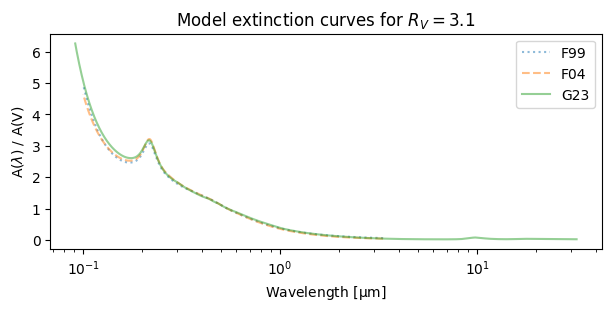

Using the G23 extinction model covers the range from 0.0912 µm to 32.0 µm.


In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=f"Wavelength [{_lambda.unit:latex_inline}]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range):unicode} to {max(ext_wl_range):unicode}.")

### Select our target and get its known information

In [5]:
default_target = "ZZ UMa"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(model_grid.teff_range * model_grid.teff_unit).to(u.K).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=26, options=(('V436 Per [too hot!]', 'V436 Per'), ('V539 Ara', 'V539 Ar…

In [6]:
target = target_selection.value
target_config = targets_cfg[target]
target_config.setdefault("loggA", log_g(target_config["MA"] * M_sun, target_config["RA"] * R_sun).n)
target_config.setdefault("loggB", log_g(target_config["MB"] * M_sun, target_config["RB"] * R_sun).n)

# Additional data on the target populated with lookups
target_data = {
    "label": target_config.get("label", target),
    "search_term": target_config.get("search_term", target)
}

_simbad = Simbad()
_simbad.add_votable_fields("sp", "ids")
if _tbl := _simbad.query_object(target_data["search_term"]):
    target_data["ids"] = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                                    dtype=[("type", object), ("id", object)])
    print(f"IDs:", ", ".join(f"{i['type']} {i['id']}" for i in target_data["ids"]))
    target_data["spt"] = _tbl["sp_type"][0]
    print(f"SpT:", target_data["spt"])

IDs: TIC 138505004, HIP 51411, Gaia DR3 1049087857023628672, V* ZZ UMa, 2MASS J10300318+6148413
SpT: F8


In [7]:
# Let's get the Gaia DR3 data on this here object
_gaia_dr3_id = target_data["ids"][target_data["ids"]["type"] == "Gaia DR3"]["id"][0]
if _job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}"):
    _tbl = _job.get_results()
    target_data["parallax_mas"] = ufloat(_tbl["parallax"][0], _tbl["parallax_error"][0])
    target_data["skycoords"] = _coords = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                                  distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
    print(f"{target} SkyCoords are {_coords} (or {_coords.to_string('hmsdms')})")
    target_data["bp_rp"] = _tbl["bp_rp"][0]
    target_data["phot_g_mean_mag"] = _tbl["phot_g_mean_mag"][0]
    target_data["ruwe"] = _tbl["ruwe"][0]

ZZ UMa SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (157.51348179, 61.81150046, 180.19865046)> (or 10h30m03.2356293s +61d48m41.40164351s)


In [8]:
# Lookup the TESS Input Catalog (8.2) for starting "system" Teff and logg values
target_data["teff_sys"] = get_teff_from_spt(target_data["spt"]) or ufloat(5700, 0)
target_data["logg_sys"] = ufloat(4.0, 0)
if _tbl := Vizier(catalog="IV/39/tic82").query_object(target_data["search_term"], radius=0.1 * u.arcsec):
    if _row := _tbl[0][_tbl[0]["TIC"] in target_data["ids"][target_data["ids"]["type"] == "TIC"]["id"]]:
        # Teff may not be reliable - only use it if it's consistent with the SpT
        if target_data["teff_sys"].n-target_data["teff_sys"].s < (_row["Teff"] or 0) < target_data["teff_sys"].n+target_data["teff_sys"].s:
            target_data["teff_sys"] = ufloat(_row["Teff"], _row.get("s_Teff", None) or 0)
        if (_row["logg"] or 0) > 0:
            target_data["logg_sys"] = ufloat(_row["logg"], _row.get("s_logg", None) or 0)

# Other priors will likely come out of light curve fitting with JKTEBOP - get from config for now
target_data["k"] = ufloat(target_config.get("k"), target_config.get("k_err", 0) or 0)
if "light_ratio" in target_config:
    target_data["light_ratio"] = ufloat(target_config.get("light_ratio"), target_config.get("light_ratio_err", 0) or 0)
else:
    # If from LC fit we may also need to consider l3; lA=(1-l3)/(1+(LB/LA)) & lB=(1-l3)/(1+1/(LB/LA))
    target_data["light_ratio"] = ufloat(10**(target_config.get("logLB", 1) - target_config.get("logLA", 1)), 0)
target_data["teff_ratio"] = (target_data["light_ratio"] / target_data["k"]**2)**0.25

# Estimate the teffs, based on the published system value and the ratio from fitting
if target_data["teff_ratio"].n <= 1:
    target_data["teffs0"] = [target_data["teff_sys"].n, (target_data["teff_sys"] * target_data["teff_ratio"]).n]
else:
    target_data["teffs0"]  = [(target_data["teff_sys"] / target_data["teff_ratio"]).n, target_data["teff_sys"].n]

print(f"{target} system values from lookup and LC fitting:")
for p, unit in [("teff_sys", u.K), ("logg_sys", u.dex), ("k", None), ("light_ratio", None), ("teff_ratio", None)]:
    print(f"{p:>12s} = {target_data[p]:.3f} {unit or u.dimensionless_unscaled:unicode}")
print(f"      teffs0 = [{', '.join(f'{t:.3f}' for t in target_data['teffs0'])}]")

ZZ UMa system values from lookup and LC fitting:
    teff_sys = 6700.000+/-500.000 K
    logg_sys = 3.993+/-0.075 dex
           k = 0.748+/-0.004 
 light_ratio = 0.343+/-0 
  teff_ratio = 0.884+/-0.002 
      teffs0 = [6700.000, 5925.949]


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- remove duplicate SED measurements
- group and average SED measurements by filter & frequency
- exclude measurements outside the range of our extinction model
- optionally exclude flux outliers

In [9]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Work in Jy rather than W/m^2/Hz as they are a more natural unit, giving values that minimize 
# potential FP rounding. Plots are agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, target_data["search_term"], radius=0.1, remove_duplicates=True,
                         freq_unit=u.GHz, flux_unit=u.Jy, wl_unit=u.um, verbose=True)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= model_grid.has_filter(sed["sed_filter"])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) \
            & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_grid.wavelength_range)) \
            & (sed["sed_wl"] <= max(model_grid.wavelength_range)) \
            & (sed["sed_wl"] <= 22 * u.um)
sed = sed[model_mask]

out_mask = create_outliers_mask(sed, target_data["teffs0"], min_unmasked=15, verbose=True)
sed = sed[~out_mask]

sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux density, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table zz-uma-0.1.vot containing 75 row(s).
Dropped 29 duplicate(s) leaving 46 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 20 group(s) from 46 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
No outliers masked as already 15 or fewer SED rows
14 unique SED observation(s) retained after range and outlier filtering 
with the units for flux density, frequency and wavelength being Jy, GHz, µm


### De-redden the SED
Use the target coordinates to find an $E(B-V)$ value from the available extinction maps.
With this we can deredden the remaining SED fluxes using the previously created extinction model. 

In [10]:
for val, flags in extinction.get_ebv(target_data["skycoords"], rv=ext_model.Rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.261 s
  pix_info:   0.343 s
   samples:  14.201 s
      best:   2.778 s
       nan:   0.021 s
      sort:   7.839 s
       idx:   0.080 s
Querying Galactic interstellar dust Gaia-2MASS 3D maps (2022A&A...664A.174V) for extinction data.
Found extinction with get_vergely_av: E(B-V) = 0.001547


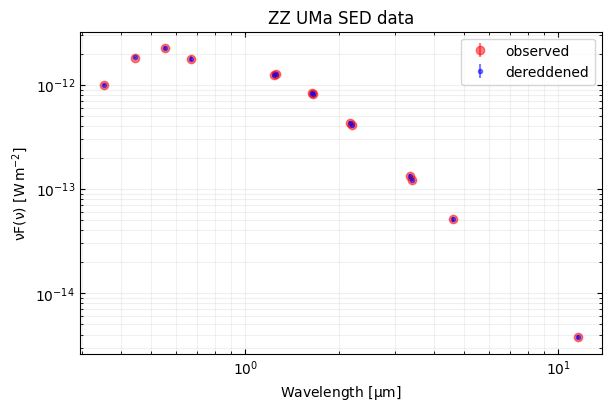

In [11]:
fig = plot_sed(sed["sed_wl"].quantity,
               fluxes=[sed["sed_flux"].quantity, sed["sed_der_flux"].quantity],
               flux_errs=[sed["sed_eflux"].quantity]*2,
               fmts=["or", ".b"],
               labels=["observed", der_lab],
               title=target_data['label'] + " SED data")
plt.show(fig)
plt.close(fig)

### Set up the functions which will support fitting

This is a function which plots the fitted vs observed SED data.

In [12]:
def plot_fitted_model(sed, theta, title):
    # Generate model SED fluxes at points x for each set of component star params in theta
    x = model_grid.get_filter_indices(sed["sed_filter"])
    th = nominal_values(theta)
    comp_fluxes = model_func(th, x, model_grid, combine=False) * model_grid.flux_unit
    sys_flux = np.sum(comp_fluxes, axis=0)

    # Plot the fitted model against the derredened SED + show each star's contribution
    fig = plot_sed(x=sed["sed_wl"].to(u.um),
                   fluxes=[sed["sed_der_flux"].quantity, sys_flux, comp_fluxes[0], comp_fluxes[1]],
                   flux_errs=[sed["sed_eflux"].quantity, None, None, None],
                   fmts=["ob", ".k", "*g", "xr"],
                   labels=["dereddened SED", "fitted pair", "fitted star A", "fitted star B"],
                   title=title)

    # Plot the raw spectra for each component as a background
    spec_lams = model_grid.wavelengths * model_grid.wavelength_unit
    mask = (spec_lams >= sed["sed_wl"].quantity.min()) & (spec_lams <= sed["sed_wl"].quantity.max())
    dist = th[-1]
    for teff, rad, logg, c in [(th[0], th[2], th[4], "g"), (th[1], th[3], th[5], "r")]:
        spec_flux = model_grid.get_fluxes(teff, logg, 0, rad, dist) * model_grid.flux_unit
        fig.gca().plot(spec_lams[mask], spec_flux[mask], c=c, alpha=0.15, zorder=-100)

    plt.show(fig)
    plt.close(fig)

We set the starting position for the fit, `theta0`, which is our best estimate of the
fitted values for the system based on existing published data and any light-curve fitting carried
out previously.

The `fit_mask` indicates which of the values in `theta0` is fitted, with the remainder being fixed.

**Note:** currently we're not fitting for $\log{g}$, instead using fixed values for each star.

In [13]:
theta_plot_labels = np.array([r"$T_{\rm eff,A} / {\rm K}$", r"$T_{\rm eff,B} / {\rm K}$",
                              r"$R_{\rm A} / {\rm R_{\odot}}$", r"$R_{\rm B} / {\rm R_{\odot}}$",
                              r"$\log{g}_{\rm A}$", r"$\log{g}_{\rm B}$",
                              r"${\rm distance} / {\rm m}$"])
theta_labels = np.array([("TeffA", u.K), ("TeffB", u.K), ("RA", u.Rsun), ("RB", u.Rsun),
                         ("loggA", u.dex), ("loggB", u.dex), ("dist", u.pc)])

NUM_STARS = 2
theta0 = create_theta(teffs=target_data["teffs0"].copy(),
                      radii=[1.0] * NUM_STARS,
                      loggs=[target_data["logg_sys"].n] * NUM_STARS,
                      dist=target_data["skycoords"].distance.to(u.pc).value,
                      nstars=NUM_STARS,
                      verbose=True)

fit_mask = np.array([True] * NUM_STARS      # teff
                  + [True] * NUM_STARS      # radius
                  + [False] * NUM_STARS     # logg
                  + [False])                # dist

print(f"For {target} we set the starting position (theta0) to be:",
    *(f"\n{l:>9s} = {theta0[ix]:.3f} {unit:unicode}" for ix, (l, unit) in enumerate(theta_labels)))

theta:	 6.700e+03, 5.926e+03, 1.000e+00, 1.000e+00, 3.993e+00, 3.993e+00, 1.802e+02
For ZZ UMa we set the starting position (theta0) to be: 
    TeffA = 6700.000 K 
    TeffB = 5925.949 K 
       RA = 1.000 R☉ 
       RB = 1.000 R☉ 
    loggA = 3.993 dex 
    loggB = 3.993 dex 
     dist = 180.199 pc


Here we set up priors' limit and ratio criteria for the fitting. This is in the form of a
callback function which the fitting code invokes at the start of each iteration.

In [14]:
# For now, hard coded to 2 stars. Same order as theta: teff, radii (, logg, dist are not fitted)
teff_limits = model_grid.teff_range
radius_limits = (0.1, 100)
teff_ratio = (target_data["teff_ratio"].n, max(target_data["teff_ratio"].n * 0.05, target_data["teff_ratio"].s))
radius_ratio = (target_data["k"].n, max(target_data["k"].n * 0.05, target_data["k"].s))

def ln_prior_func(theta: np.ndarray[float]) -> float:
    """
    The fitting prior callback function to evaluate the current set of candidate
    parameters (theta), returning a single ln(value) indicating their "goodness".
    """
    teffs, radii = theta[0:2], theta[2:4]

    # Limit criteria checks - hard pass/fail on these
    if not all(teff_limits[0] <= t <= teff_limits[1] for t in teffs) or \
        not all(radius_limits[0] <= r <= radius_limits[1] for r in radii):
        return np.inf

    # Gaussian prior criteria: g(x) = 1/(σ*sqrt(2*pi)) * exp(-1/2 * (x-µ)^2/σ^2)
    # Omitting scaling expressions for now and note the implicit ln() cancelling the exp
    return 0.5 * np.sum([
        ((teffs[1] / teffs[0] - teff_ratio[0]) / teff_ratio[1])**2,
        ((radii[1] / radii[0] - radius_ratio[0]) / radius_ratio[1])**2,
    ])

Get the observed SED data into a format for fitting.

In [15]:
# Prepare the data to be fitted
x = model_grid.get_filter_indices(sed["sed_filter"])
y = (sed["sed_der_flux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value
y_err = (sed["sed_eflux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value

### Initial (quick) minimize fit.

In [16]:
theta_min, soln = minimize_fit(x, y, y_err=y_err, theta0=theta0, fit_mask=fit_mask,
                               ln_prior_func=ln_prior_func, stellar_grid=model_grid, verbose=True)

minimize_fit(theta0=[6.700e+03*, 5.926e+03*, 1.000e+00*, 1.000e+00*, 3.993e+00, 3.993e+00, 1.802e+02])
(Nelder-Mead) succeeded after 160 iterations & 288 function evaluation(s) [fun = 3.875861]
(SLSQP) succeeded after 30 iterations & 157 function evaluation(s) [fun = 3.875861]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 42 iterations & 466 function evaluation(s) [fun = 3.875861]
The best fit with Nelder-Mead method yielded theta=[6.088e+03*, 5.338e+03*, 1.406e+00*, 1.052e+00*, 3.993e+00, 3.993e+00, 1.802e+02]


Best fit parameters for ZZ UMa from the 'minimize' fit
       TeffA = 6088.100 K (known value 5960.000+/-70.000)
       TeffB = 5337.835 K (known value 5270.000+/-90.000)
          RA = 1.406 R☉ (known value 1.437+/-0.007)
          RB = 1.052 R☉ (known value 1.075+/-0.005)


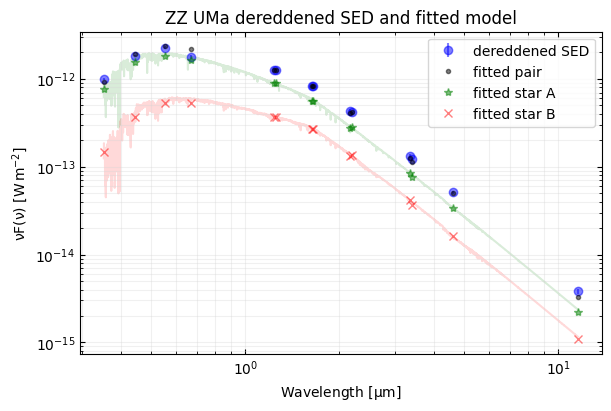

In [17]:
print(f"Best fit parameters for {target} from the 'minimize' fit")
for ix, (l, unit) in enumerate(theta_labels[fit_mask]):
    known_val = ufloat(target_config.get(l, np.NaN), target_config.get(l + "_err", None) or 0)
    print(f"{l:>12s} = {theta_min[fit_mask][ix]:.3f} {unit:unicode} (known value {known_val:.3f})")

plot_fitted_model(sed, theta_min, f"{target_data['label']} dereddened SED and fitted model")

### Perform MCMC fitting for a more reliable fit with uncertainties from a probability distribution

In [18]:
thin_by = 10 # sample every nth step from the chain
theta_mcmc, sampler = mcmc_fit(x, y, y_err, theta0=theta_min, fit_mask=fit_mask,
                               ln_prior_func=ln_prior_func, stellar_grid=model_grid, 
                               nwalkers=100, nsteps=100000, thin_by=thin_by, seed=42,
                               early_stopping=True, processes=8, progress=True, verbose=True)

mcmc_fit(theta0=[6.088e+03*, 5.338e+03*, 1.406e+00*, 1.052e+00*, 3.993e+00, 3.993e+00, 1.802e+02])
Running MCMC fit with 100 walkers for 100000 steps, thinned by 10, on 8 process(es). Early stopping is enabled after 2500 steps.


 15%|█▌        | 15000/100000 [20:43<1:57:26, 12.06it/s]


Halting MCMC after 15000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Autocorrelation steps (tau): 46.106, 47.528, 44.797, 47.122
Estimated burn-in steps:     95
Mean Acceptance fraction:    0.592
The MCMC fit yielded theta:  [(6.086+/-0.074)e+03*, (5.330+/-0.230)e+03*, (1.408+/-0.030)e+00*, (1.052+/-0.036)e+00*, (3.993+/-0)e+00, (3.993+/-0)e+00, (1.802+/-0)e+02]


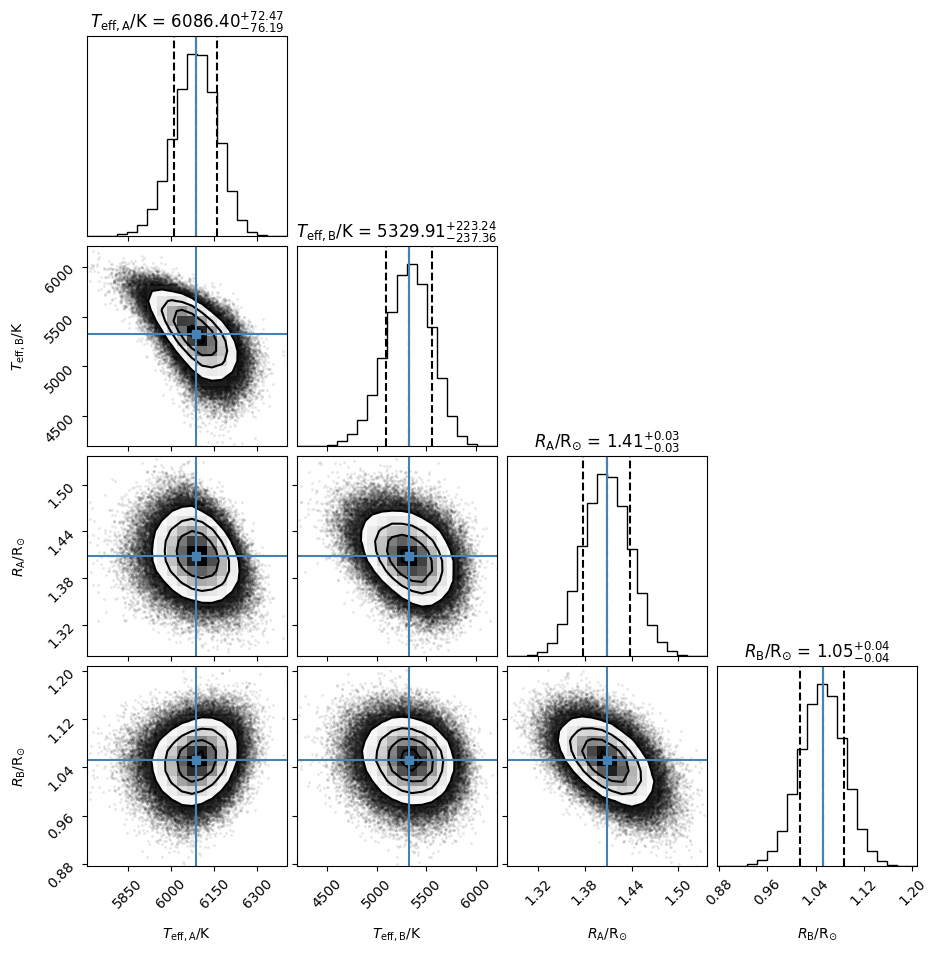

In [19]:
tau = sampler.get_autocorr_time(c=5, tol=50, quiet=True) * thin_by
burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
samples = sampler.get_chain(discard=burn_in_steps, flat=True)
plt.show(corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                       labels=theta_plot_labels[fit_mask], truths=nominal_values(theta_mcmc[fit_mask])))
plt.close()


Final parameters for ZZ UMa with nominals & 1-sigma error bars from MCMC fit
       TeffA = 6086.397+/-74.330 K (known value 5960.000+/-70.000 K)
       TeffB = 5329.868+/-230.298 K (known value 5270.000+/-90.000 K)
          RA = 1.408+/-0.030 R☉ (known value 1.437+/-0.007 R☉)
          RB = 1.052+/-0.036 R☉ (known value 1.075+/-0.005 R☉)


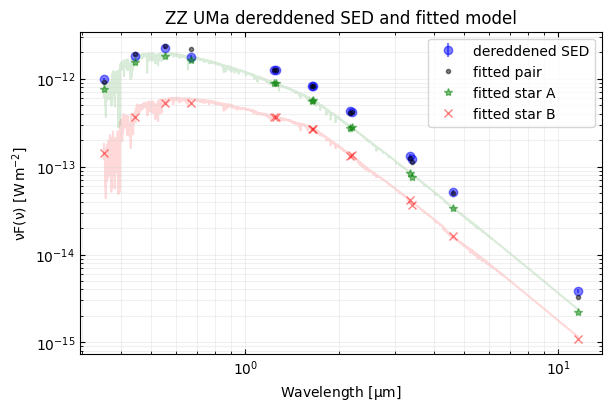

In [20]:
print(f"\nFinal parameters for {target} with nominals & 1-sigma error bars from MCMC fit")
for (param, unit), fit in zip(theta_labels[fit_mask], theta_mcmc[fit_mask]):
    known = ufloat(target_config.get(param, np.NaN), target_config.get(param+"_err", None) or 0)
    print(f"{param:>12s} = {fit:.3f} {unit:unicode} (known value {known:.3f} {unit:unicode})")

plot_fitted_model(sed, theta_mcmc, f"{target_data['label']} dereddened SED and fitted model")